In [ ]:
# customary imports:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import tqdm
from sklearn.model_selection import StratifiedKFold

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
def load_normalize(image_path, normalized=True):
    image = Image.open(image_path).resize([128,128])
    image= np.array(image).astype(np.float32)
    if len(image.shape) == 3:
        image = image.sum(axis=2)
    if normalized:
        return image / 255.0
    else:
        return image

In [ ]:
# code to load all the data, assuming dataset is at /workspaces/awesome-ml-group/00_source_data/images/train
emo_types = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
emo_inds = np.arange(0, len(emo_types))

In [ ]:
x_data = []
y_data = []

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/content/gdrive/MyDrive/Expression Dataset/Train_Relabeled_Cleaned/', emo_types[emo_ind],'*.jpg'))
    # x_data += [load_extract_normalize(image_path) for image_path in all_images]
    x_data += [load_normalize(image_path) for image_path in all_images]
    y_data += [emo_ind]*len(all_images)

In [ ]:
from numpy import save
from google.colab import files
save('/content/gdrive/MyDrive/ML Final project/x_data.npy', x_data)
save('/content/gdrive/MyDrive/ML Final project/y_data.npy', y_data)

In [ ]:
from numpy import load
x_data = load('/content/gdrive/MyDrive/ML Final project/x_data.npy')


In [ ]:
y_data = load('/content/gdrive/MyDrive/ML Final project/y_data.npy')

## Forehead Mask (top 1/4 of the face)

In [ ]:
def forehead_mask(img,dim):
    l,r,t,b = 0,dim,0,int(dim/4)
    img[t:b,l:r] = 0   
    return img

In [ ]:
x_data = [forehead_mask(img,128) for img in x_data]

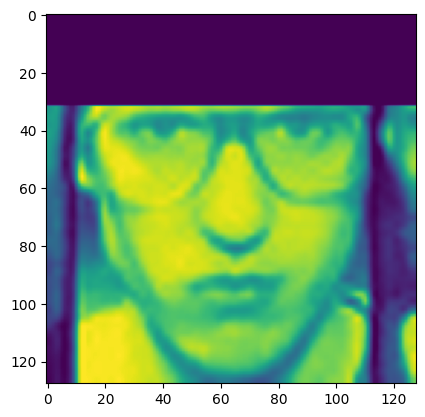

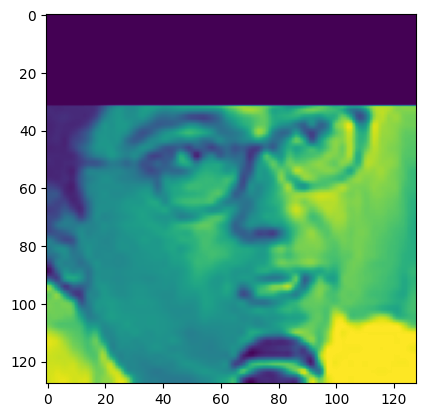

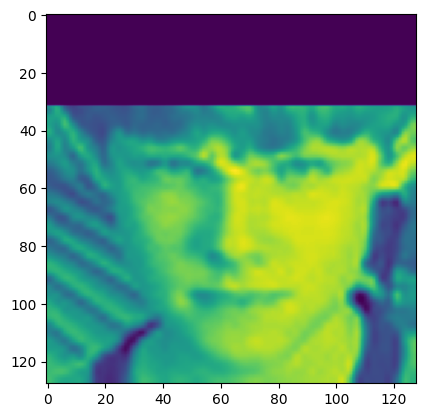

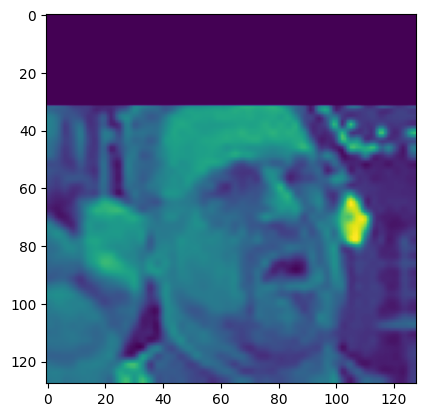

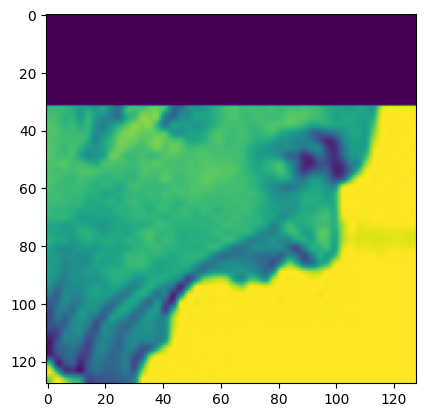

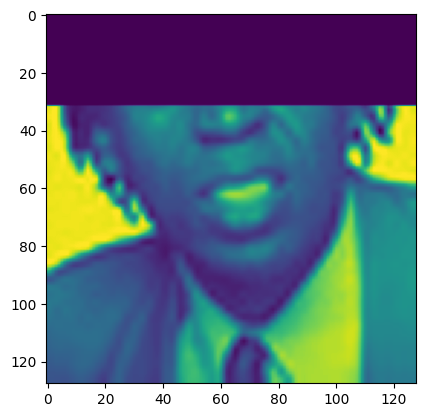

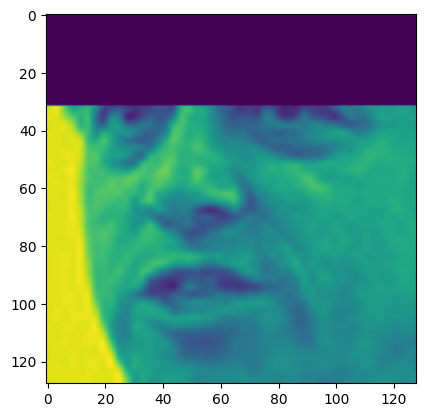

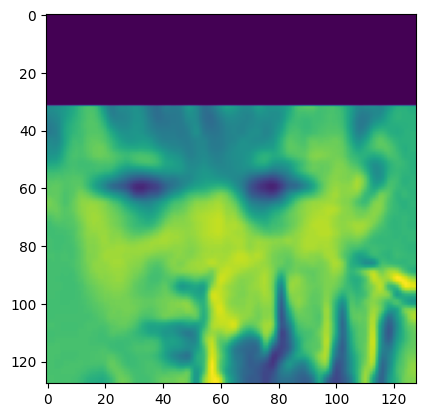

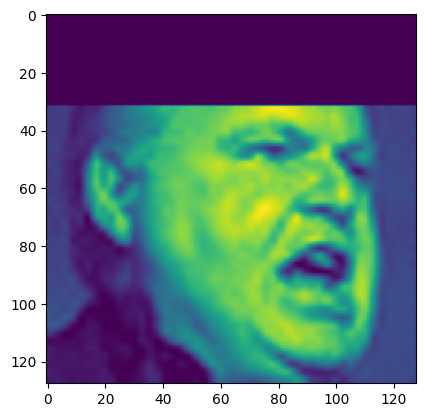

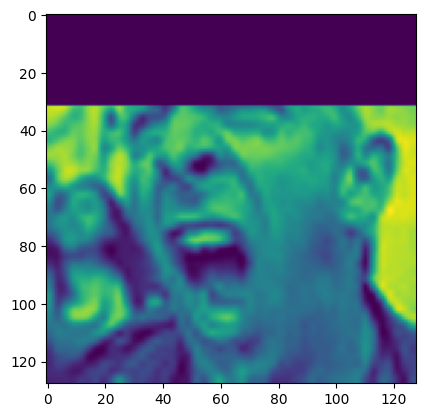

In [ ]:
for i in range(10):
    plt.imshow(x_data[i])
    plt.show()

In [ ]:
save('/content/gdrive/MyDrive/ML Final project/x_data_forehead_mask.npy', x_data)
# files.download("x_data_eye_mask.npy")

(22036, 128, 128, 1) (22036, 7)
(5510, 128, 128, 1) (5510, 7)


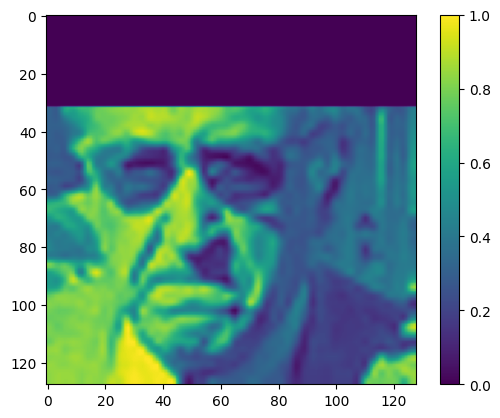

In [ ]:
# adding a fake color channel
x_data = np.array(x_data).reshape(-1, 128, 128, 1)
y_data = np.array(y_data)

folder = StratifiedKFold(5, shuffle=True)
x_indices = np.arange(0, len(x_data))
train_indices, val_indices = folder.split(x_indices, y_data).__next__()
# shuffling
np.random.shuffle(train_indices)

x_train = x_data[train_indices]
y_train = np.eye(len(emo_types))[y_data[train_indices]]

x_val = x_data[val_indices]
y_val = np.eye(len(emo_types))[y_data[val_indices]]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

plt.imshow(x_train[0,:,:,0])
plt.colorbar()

In [ ]:
VGG16_model_bn_forehead = tf.keras.models.Sequential([
    
    # Input layer
    tf.keras.layers.Input(x_train[0].shape),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=64,kernel_size=3, padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3, padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=128,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=256,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # dense layer:
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    # Batch Normalisation layer:
    tf.keras.layers.BatchNormalization(),


    # output layer:
    tf.keras.layers.Dense(7, activation='softmax')
])

In [ ]:
VGG16_model_bn_forehead.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),  # pick an optimizer and learning rate
                     loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss
                     metrics=tf.keras.metrics.CategoricalAccuracy())  # pick a metric to monitor

In [ ]:
n_epoch = 30
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
hist = VGG16_model_bn_forehead.fit(x_train, y_train,
              epochs=n_epoch,
              batch_size=32,
              validation_data=(x_val, y_val),
              callbacks=[callback])

Epoch 1/30
689/689 [==============================] - 129s 155ms/step - loss: 2.0646 - categorical_accuracy: 0.2657 - val_loss: 1.6961 - val_categorical_accuracy: 0.3613
Epoch 2/30
689/689 [==============================] - 105s 153ms/step - loss: 1.5853 - categorical_accuracy: 0.4120 - val_loss: 1.4683 - val_categorical_accuracy: 0.4468
Epoch 3/30
689/689 [==============================] - 105s 152ms/step - loss: 1.3487 - categorical_accuracy: 0.4935 - val_loss: 1.3499 - val_categorical_accuracy: 0.4862
Epoch 4/30
689/689 [==============================] - 105s 152ms/step - loss: 1.2019 - categorical_accuracy: 0.5503 - val_loss: 1.3816 - val_categorical_accuracy: 0.4904
Epoch 5/30
689/689 [==============================] - 105s 152ms/step - loss: 1.1229 - categorical_accuracy: 0.5828 - val_loss: 1.2655 - val_categorical_accuracy: 0.5243
Epoch 6/30
689/689 [==============================] - 105s 152ms/step - loss: 1.0193 - categorical_accuracy: 0.6212 - val_loss: 1.0958 - val_categoric

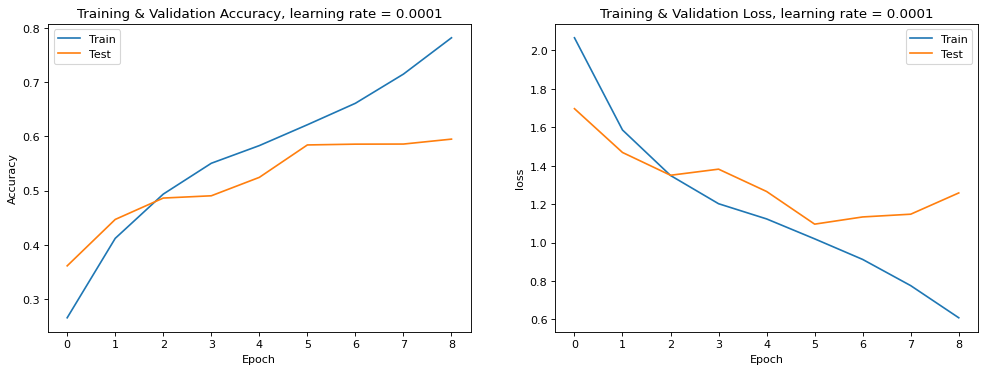

In [ ]:
n_epoch = 9
plt.figure(figsize=(15, 5), dpi=80)
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.plot(np.arange(n_epoch),hist.history.get('categorical_accuracy'), label="Train")
plt.plot(np.arange(n_epoch),hist.history.get('val_categorical_accuracy'), label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.title("Training & Validation Accuracy, learning rate = 0.0001")

plt.subplot(1, 2, 2) # index 2
plt.plot(np.arange(n_epoch),hist.history.get('loss'), label="Train")
plt.plot(np.arange(n_epoch),hist.history.get('val_loss'), label="Test")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend(loc='best')
plt.title("Training & Validation Loss, learning rate = 0.0001")
plt.show()

In [ ]:
# VGG16_model_bn_forehead.save('/content/gdrive/MyDrive/ML Final project/VGG16_model_bn_forehead')

In [ ]:
VGG16_model_bn_forehead.save_weights('/content/gdrive/MyDrive/ML Final project/VGG16_model_bn_forehead')

In [ ]:
VGG16_model_bn_forehead.load_weights('/content/gdrive/MyDrive/ML Final project/VGG16_model_bn_forehead')

## Test model

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report

In [ ]:
# code to load all the data, assuming dataset is at /workspaces/awesome-ml-group/00_source_data/images/train
x_test = []
y_test = []

# # Load the cascade
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/content/gdrive/MyDrive/Expression Dataset/Validation_Relabeled_Cleaned', emo_types[emo_ind],'*.jpg'))
    # x_data += [load_extract_normalize(image_path) for image_path in all_images]
    x_test += [load_normalize(image_path) for image_path in all_images]
    y_test += [emo_ind]*len(all_images)

In [ ]:
# adding a fake color channel
x_test = np.array(x_test).reshape(-1, 128, 128, 1)
y_test = np.array(y_test)

# folder = StratifiedKFold(5, shuffle=True)
# x_indices = np.arange(0, len(x_data))
# train_indices, val_indices = folder.split(x_indices, y_data).__next__()
# # shuffling
# np.random.shuffle(train_indices)

# x_train = x_data[train_indices]
# y_train = np.eye(len(emo_types))[y_data[train_indices]]
y_test = np.eye(len(emo_types))[y_test]

# x_val = x_data[val_indices]
# y_val = np.eye(len(emo_types))[y_data[val_indices]]

print(x_test.shape, y_test.shape)

(6488, 128, 128, 1) (6488, 7)


In [ ]:
# Evaluate the model
loss, acc = VGG16_model_bn_forehead.evaluate(x_test, y_test, verbose=2)
print("VGG 16 model, accuracy: {:5.2f}%".format(100 * acc))
y_pred = VGG16_model_bn_forehead.predict(x_test, verbose=2)

203/203 - 386s - loss: 1.4047 - categorical_accuracy: 0.5749 - 386s/epoch - 2s/step
VGG 16 model, accuracy: 57.49%
203/203 - 380s - 380s/epoch - 2s/step


In [ ]:
y_pred = np.argmax(y_pred,axis = 1)
y_test = np.argmax(y_test,axis = 1)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.49      0.50      0.50       888
           1       0.55      0.20      0.30        83
           2       0.47      0.30      0.37       916
           3       0.78      0.86      0.82      1752
           4       0.43      0.77      0.55      1181
           5       0.51      0.26      0.34      1088
           6       0.78      0.52      0.62       580

    accuracy                           0.57      6488
   macro avg       0.57      0.49      0.50      6488
weighted avg       0.59      0.57      0.56      6488



In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
matrix.diagonal()/matrix.sum(axis=1)

array([0.49662162, 0.20481928, 0.30349345, 0.86073059, 0.76883997,
       0.25551471, 0.51724138])

## Eye Maks (upper 1/4 of the face)

In [ ]:
x_data_1 = x_data.copy()

In [ ]:
def eye_mask(img,dim):
    l,r,t,b = 0,dim,int(dim/4),int(dim/2)
    img[t:b,l:r] = 0   
    return img 

In [ ]:
x_data = [eye_mask(img,128) for img in x_data]

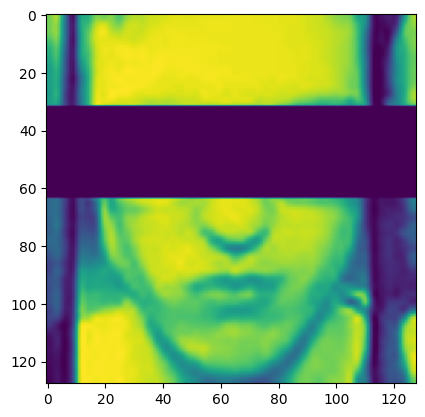

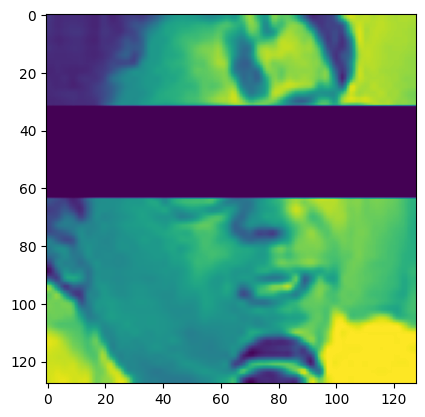

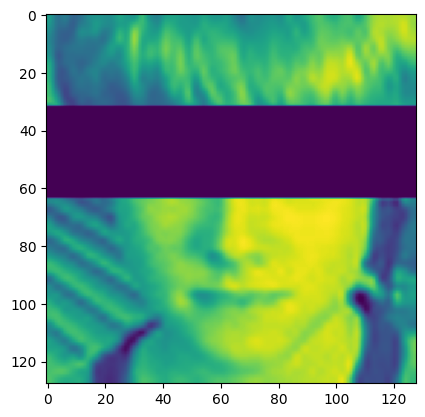

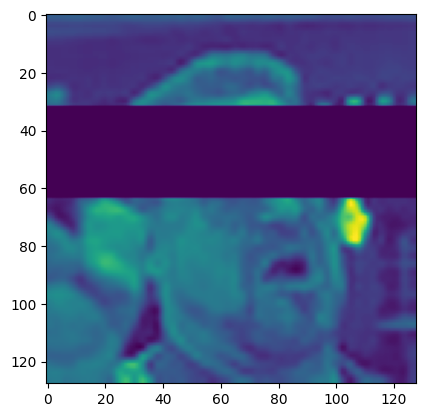

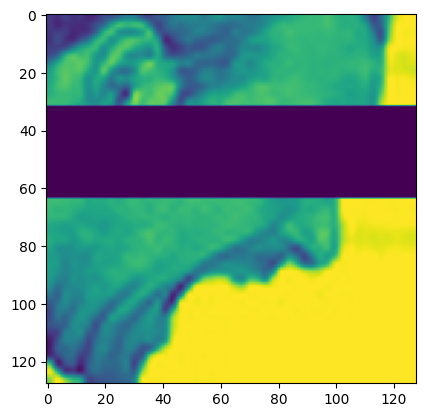

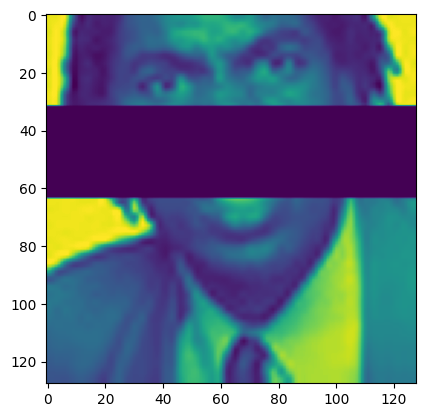

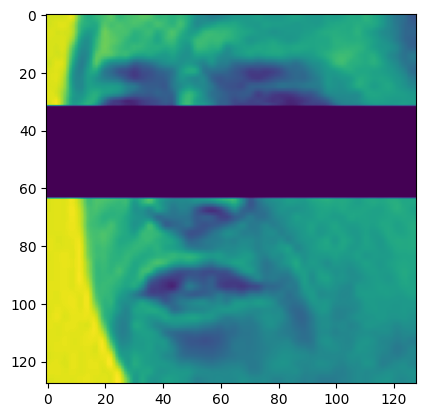

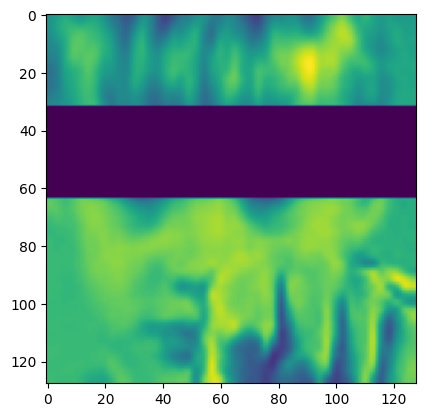

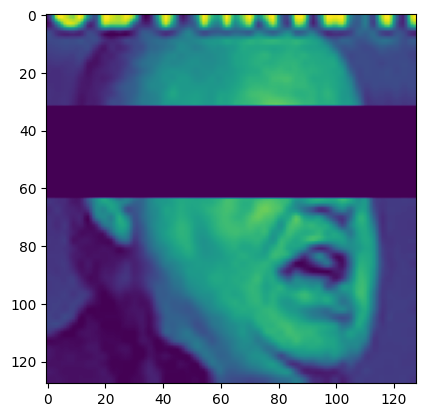

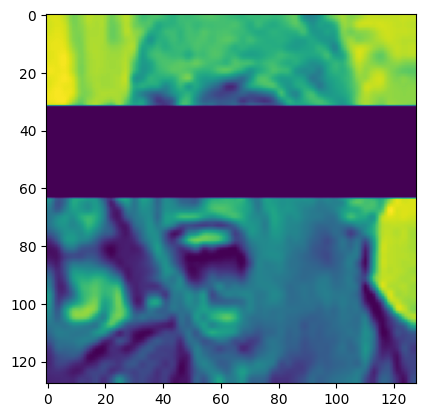

In [ ]:
for i in range(10):
    plt.imshow(x_data[i])
    plt.show()

In [ ]:
save('/content/gdrive/MyDrive/ML Final project/x_data_eye_mask.npy', x_data)
# files.download("x_data_eye_mask.npy")

In [ ]:
x_data = load('/content/x_data_eye_mask.npy')

(22036, 128, 128, 1) (22036, 7)
(5510, 128, 128, 1) (5510, 7)


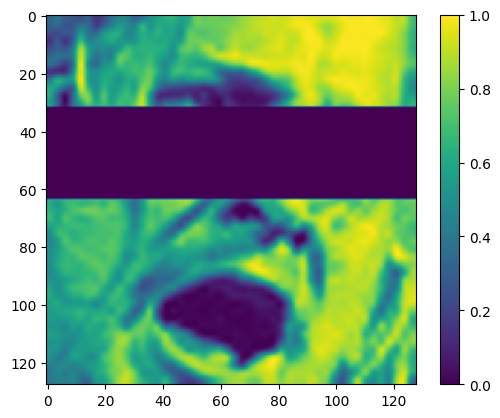

In [ ]:
# adding a fake color channel
x_data = np.array(x_data).reshape(-1, 128, 128, 1)
y_data = np.array(y_data)

folder = StratifiedKFold(5, shuffle=True)
x_indices = np.arange(0, len(x_data))
train_indices, val_indices = folder.split(x_indices, y_data).__next__()
# shuffling
np.random.shuffle(train_indices)

x_train = x_data[train_indices]
y_train = np.eye(len(emo_types))[y_data[train_indices]]

x_val = x_data[val_indices]
y_val = np.eye(len(emo_types))[y_data[val_indices]]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

plt.imshow(x_train[0,:,:,0])
plt.colorbar()

(23064, 256, 256, 1) (23064, 7)
(5767, 256, 256, 1) (5767, 7)


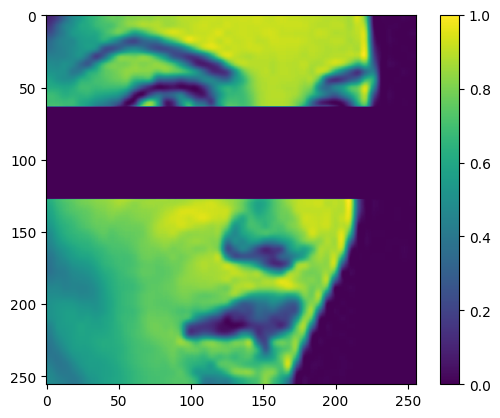

In [ ]:
# # adding a fake color channel
# x_data_1 = np.array(x_data_1).reshape(-1, 256, 256, 1)
# y_data = np.array(y_data)

# folder = StratifiedKFold(5, shuffle=True)
# x_indices = np.arange(0, len(x_data_1))
# train_indices, val_indices = folder.split(x_indices, y_data).__next__()
# # shuffling
# np.random.shuffle(train_indices)

# x_train = x_data_1[train_indices]
# y_train = np.eye(len(emo_types))[y_data[train_indices]]

# x_val = x_data_1[val_indices]
# y_val = np.eye(len(emo_types))[y_data[val_indices]]

# print(x_train.shape, y_train.shape)
# print(x_val.shape, y_val.shape)

# plt.imshow(x_train[0,:,:,0])
# plt.colorbar()

In [ ]:
VGG16_model_bn_eye = tf.keras.models.Sequential([
    
    # Input layer
    tf.keras.layers.Input(x_train[0].shape),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=64,kernel_size=3, padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3, padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=128,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=256,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # dense layer:
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    # Batch Normalisation layer:
    tf.keras.layers.BatchNormalization(),


    # output layer:
    tf.keras.layers.Dense(7, activation='softmax')
])

In [ ]:
VGG16_model_bn_eye.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),  # pick an optimizer and learning rate
                     loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss
                     metrics=tf.keras.metrics.CategoricalAccuracy())  # pick a metric to monitor

In [ ]:
n_epoch = 30
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
hist = VGG16_model_bn_eye.fit(x_train, y_train,
              epochs=n_epoch,
              batch_size=32,
              validation_data=(x_val, y_val),
              callbacks=[callback])

Epoch 1/30
689/689 [==============================] - 127s 151ms/step - loss: 2.1084 - categorical_accuracy: 0.2417 - val_loss: 1.8426 - val_categorical_accuracy: 0.2737
Epoch 2/30
689/689 [==============================] - 103s 149ms/step - loss: 1.6540 - categorical_accuracy: 0.3836 - val_loss: 1.5016 - val_categorical_accuracy: 0.4103
Epoch 3/30
689/689 [==============================] - 103s 149ms/step - loss: 1.3991 - categorical_accuracy: 0.4681 - val_loss: 1.3589 - val_categorical_accuracy: 0.4802
Epoch 4/30
689/689 [==============================] - 103s 149ms/step - loss: 1.2976 - categorical_accuracy: 0.5142 - val_loss: 1.2543 - val_categorical_accuracy: 0.5149
Epoch 5/30
689/689 [==============================] - 103s 149ms/step - loss: 1.2071 - categorical_accuracy: 0.5506 - val_loss: 1.2262 - val_categorical_accuracy: 0.5334
Epoch 6/30
689/689 [==============================] - 103s 149ms/step - loss: 1.1160 - categorical_accuracy: 0.5825 - val_loss: 1.2518 - val_categoric

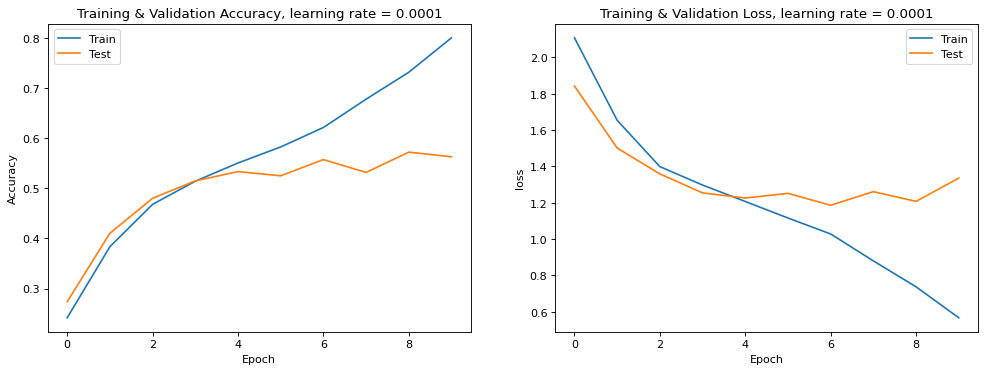

In [ ]:
n_epoch = 10
plt.figure(figsize=(15, 5), dpi=80)
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.plot(np.arange(n_epoch),hist.history.get('categorical_accuracy'), label="Train")
plt.plot(np.arange(n_epoch),hist.history.get('val_categorical_accuracy'), label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.title("Training & Validation Accuracy, learning rate = 0.0001")

plt.subplot(1, 2, 2) # index 2
plt.plot(np.arange(n_epoch),hist.history.get('loss'), label="Train")
plt.plot(np.arange(n_epoch),hist.history.get('val_loss'), label="Test")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend(loc='best')
plt.title("Training & Validation Loss, learning rate = 0.0001")
plt.show()

In [ ]:
# VGG16_model_bn_eye.save('/content/gdrive/MyDrive/ML Final project/VGG16_model_bn_eye')

In [ ]:
VGG16_model_bn_eye.save_weights('/content/gdrive/MyDrive/ML Final project/VGG16_model_bn_eye')

## Lower face mask (bottom 1/2 of the face)

In [ ]:
def lower_face_mask(img,dim):
    l,r,t,b = 0,dim,int(dim/2),dim
    img[t:b,l:r] = 0   
    return img 

In [ ]:
x_data = [lower_face_mask(img,128) for img in x_data]

In [ ]:
save('/content/gdrive/MyDrive/ML Final project/x_data_bottom_mask.npy', x_data)
# files.download("x_data_eye_mask.npy")

(22036, 128, 128, 1) (22036, 7)
(5510, 128, 128, 1) (5510, 7)


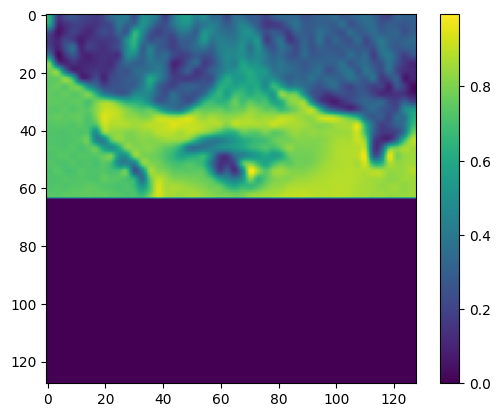

In [ ]:
# adding a fake color channel
x_data = np.array(x_data).reshape(-1, 128, 128, 1)
y_data = np.array(y_data)

folder = StratifiedKFold(5, shuffle=True)
x_indices = np.arange(0, len(x_data))
train_indices, val_indices = folder.split(x_indices, y_data).__next__()
# shuffling
np.random.shuffle(train_indices)

x_train = x_data[train_indices]
y_train = np.eye(len(emo_types))[y_data[train_indices]]

x_val = x_data[val_indices]
y_val = np.eye(len(emo_types))[y_data[val_indices]]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

plt.imshow(x_train[0,:,:,0])
plt.colorbar()

In [ ]:
VGG16_model_bn_bottom = tf.keras.models.Sequential([
    
    # Input layer
    tf.keras.layers.Input(x_train[0].shape),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=64,kernel_size=3, padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3, padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=128,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=256,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # dense layer:
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    # Batch Normalisation layer:
    tf.keras.layers.BatchNormalization(),


    # output layer:
    tf.keras.layers.Dense(7, activation='softmax')
])

In [ ]:
VGG16_model_bn_bottom.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),  # pick an optimizer and learning rate
                     loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss
                     metrics=tf.keras.metrics.CategoricalAccuracy())  # pick a metric to monitor

In [ ]:
n_epoch = 30
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
hist = VGG16_model_bn_bottom.fit(x_train, y_train,
              epochs=n_epoch,
              batch_size=32,
              validation_data=(x_val, y_val),
              callbacks=[callback])

Epoch 1/30
689/689 [==============================] - 111s 149ms/step - loss: 2.1766 - categorical_accuracy: 0.1982 - val_loss: 1.8876 - val_categorical_accuracy: 0.2641
Epoch 2/30
689/689 [==============================] - 102s 148ms/step - loss: 1.9615 - categorical_accuracy: 0.2452 - val_loss: 1.7445 - val_categorical_accuracy: 0.2802
Epoch 3/30
689/689 [==============================] - 102s 147ms/step - loss: 1.8234 - categorical_accuracy: 0.2877 - val_loss: 1.7873 - val_categorical_accuracy: 0.2926
Epoch 4/30
689/689 [==============================] - 101s 147ms/step - loss: 1.7367 - categorical_accuracy: 0.3229 - val_loss: 1.6566 - val_categorical_accuracy: 0.3283
Epoch 5/30
689/689 [==============================] - 102s 148ms/step - loss: 1.6235 - categorical_accuracy: 0.3824 - val_loss: 1.5706 - val_categorical_accuracy: 0.4178
Epoch 6/30
689/689 [==============================] - 102s 148ms/step - loss: 1.5441 - categorical_accuracy: 0.4221 - val_loss: 1.4746 - val_categoric

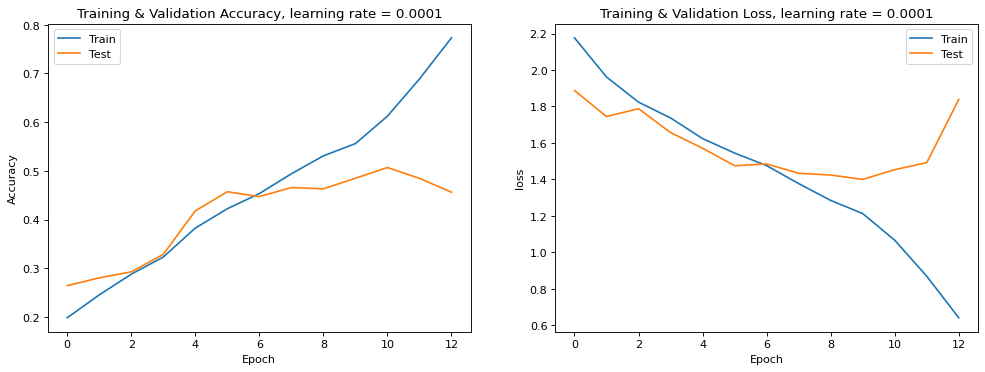

In [ ]:
n_epoch = 13
plt.figure(figsize=(15, 5), dpi=80)
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.plot(np.arange(n_epoch),hist.history.get('categorical_accuracy'), label="Train")
plt.plot(np.arange(n_epoch),hist.history.get('val_categorical_accuracy'), label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.title("Training & Validation Accuracy, learning rate = 0.0001")

plt.subplot(1, 2, 2) # index 2
plt.plot(np.arange(n_epoch),hist.history.get('loss'), label="Train")
plt.plot(np.arange(n_epoch),hist.history.get('val_loss'), label="Test")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend(loc='best')
plt.title("Training & Validation Loss, learning rate = 0.0001")
plt.show()

In [ ]:
VGG16_model_bn_bottom.save('/content/gdrive/MyDrive/ML Final project/VGG16_model_bn_bottom')

In [ ]:
VGG16_model_bn_bottom.save_weights('/content/gdrive/MyDrive/ML Final project/VGG16_model_bn_bottom')

In [ ]:
# code to load all the data, assuming dataset is at /workspaces/awesome-ml-group/00_source_data/images/train
x_test = []
y_test = []

# # Load the cascade
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/content/gdrive/MyDrive/Expression Dataset/Validation_Relabeled_Cleaned', emo_types[emo_ind],'*.jpg'))
    # x_data += [load_extract_normalize(image_path) for image_path in all_images]
    x_test += [load_normalize(image_path) for image_path in all_images]
    y_test += [emo_ind]*len(all_images)

In [ ]:
# adding a fake color channel
x_test = np.array(x_test).reshape(-1, 128, 128, 1)
y_test = np.array(y_test)

# folder = StratifiedKFold(5, shuffle=True)
# x_indices = np.arange(0, len(x_data))
# train_indices, val_indices = folder.split(x_indices, y_data).__next__()
# # shuffling
# np.random.shuffle(train_indices)

# x_train = x_data[train_indices]
# y_train = np.eye(len(emo_types))[y_data[train_indices]]
y_test = np.eye(len(emo_types))[y_test]

# x_val = x_data[val_indices]
# y_val = np.eye(len(emo_types))[y_data[val_indices]]

print(x_test.shape, y_test.shape)

(6488, 128, 128, 1) (6488, 7)


In [ ]:
# Evaluate the model
loss, acc = VGG16_model_bn_bottom.evaluate(x_test, y_test, verbose=2)
print("VGG 16 model, accuracy: {:5.2f}%".format(100 * acc))
y_pred = VGG16_model_bn_bottom.predict(x_test, verbose=2)

203/203 - 9s - loss: 1.8942 - categorical_accuracy: 0.4334 - 9s/epoch - 45ms/step
VGG 16 model, accuracy: 43.34%
203/203 - 8s - 8s/epoch - 39ms/step


In [ ]:
y_pred = np.argmax(y_pred,axis = 1)
y_test = np.argmax(y_test,axis = 1)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.63      0.23      0.34       888
           1       0.64      0.08      0.15        83
           2       0.31      0.39      0.35       916
           3       0.77      0.47      0.59      1752
           4       0.39      0.61      0.47      1181
           5       0.47      0.21      0.29      1088
           6       0.29      0.79      0.43       580

    accuracy                           0.43      6488
   macro avg       0.50      0.40      0.37      6488
weighted avg       0.52      0.43      0.43      6488

